# Appear Here Test
Goal : Answer to the two parts of appear here take home test
- part 1 : REDSHIFT SQL only writting to answer the three questions
- part 2 : ML solutions to improve booking patterns of appear here clients

Author : Pauline Guilmin

Created: **24/01/19**
Modifié le : **25/01/19**


Données utilisées : 
- ideas.csv: 
    - creation date 
    - space category
    - id
- transitions.csv
    - transition time
    - booking id
    - informations about space (id, city, country, category, floor_size, ...)
    - information about booking proposition (price, check-in,check-out, state ...)

Etapes utilisées :
- PART I : SQL 
    - 1st question
    - 2nd question
    - 3d question
- PART 2 : ML 
- import librairies
- charge datasets : 
    - import 
    - cleaning and add features
    - sort and drop duplicates
- explore **ideas**
- explore **transitions**
    - add some features : to_state_af, to_state_bf, capital, time_booked
- merge ideas and transitions : explore **total**
    - add features : time_to_booking, time_to_check_in
- suppress ideas without transitions : explore **total_ok**
- create table **conversion** 
    - pattern for each booking id
    - pattern for each new submission (submitted state)
- create table for MCA on R **booking_acm**
- ML table **booking_ml**
    - adapt features and create new 
    - correlation between features
    - deal with imbalanced data
    - Random forest 
    - Logistic regression


# import libraries

In [1]:
import numpy as np 
import pandas as pd
pd.options.display.max_colwidth = 500
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

In [2]:
!pwd

/Users/paguilmin/Documents/AppearHere_Test/analysis


# useful fonctions

In [3]:
def top_champ(df,feature,number) :
    df_ok = df.copy()
    df_ok[feature] = df_ok[feature].fillna('unknown')
    top_10 = df_ok.groupby(feature).agg('size').sort_values(ascending=False).to_frame().reset_index()
    top_10.columns=[str(x) for x in feature]+['nb_records']
    top_10['percentage']=(100.* (top_10['nb_records'] / top_10['nb_records'].sum())).round(2)
    print('%0.0f distinct values for the feature %s' %(top_10.shape[0],feature))
    return top_10.head(number)

# Charge datasets

## import csv

In [4]:
path = '../data/'
ideas = pd.read_csv(path+'ideas.csv',sep=',')
transitions = pd.read_csv(path+'transitions.csv',sep=',')

## cleaning

### supress first column unuseful

In [5]:
ideas = ideas.drop(['Unnamed: 0'],axis=1)
transitions.columns
transitions = transitions.drop(['Unnamed: 0'],axis=1)

In [6]:
# some dates are not well written : 0019 instead of 2019 and 0020 instead of 2020
transitions.loc[transitions['start_on'].str.startswith('2')==False,'start_on'] = \
transitions.loc[transitions['start_on'].str.startswith('2')==False,'start_on'].str.replace('0019','2019')
transitions.loc[transitions['end_on'].str.startswith('2')==False,'end_on'] = \
transitions.loc[transitions['end_on'].str.startswith('2')==False,'end_on'].str.replace('0020','2020')
transitions.loc[transitions['end_on'].str.startswith('2')==False,'end_on'] = \
transitions.loc[transitions['end_on'].str.startswith('2')==False,'end_on'].str.replace('0019','2019')

### check nan

In [7]:
for i in range(3) : 
    sum_na_1 = ideas.iloc[:,i].isnull().sum()#.sum()
    if sum_na_1 !=0 : print('ideas number of colonne containing nan %0.0f' %(i))
for i in range(14) : 
    sum_na_2 = transitions.iloc[:,i].isnull().sum()#.sum()
    if sum_na_2 !=0 : print('transitions number of colonne containing nan %0.0f' %(i))

### manage datetimes

In [8]:
###TRANSITIONS###
#time of booking
transitions.loc[:,'transition_ts'] = pd.to_datetime(transitions.loc[:,'transition_ts'])
transitions.loc[:,'transition_ts_year'] = transitions.loc[:,'transition_ts'].dt.year
transitions.loc[:,'transition_ts_mth'] = transitions.loc[:,'transition_ts'].dt.month

#check-in 
transitions.loc[:,'start_on'] = pd.to_datetime(transitions.loc[:,'start_on'])
transitions.loc[:,'start_on_year'] = transitions.loc[:,'start_on'].dt.year
transitions.loc[:,'start_on_mth'] = transitions.loc[:,'start_on'].dt.month

#check-out
transitions.loc[:,'end_on'] = pd.to_datetime(transitions.loc[:,'end_on'])
transitions.loc[:,'end_on_year'] = transitions.loc[:,'start_on'].dt.year
transitions.loc[:,'end_on_month'] = transitions.loc[:,'start_on'].dt.month

# time-booking
transitions['time_booked'] = transitions.loc[:,'end_on']- transitions.loc[:,'start_on']
transitions.loc[:,'time_booked'] = transitions.loc[:,'time_booked']/ np.timedelta64(1, 'D')

In [9]:
###IDEAS###
#time of creation
ideas.loc[:,'created_at'] = pd.to_datetime(ideas.loc[:,'created_at'])
ideas.loc[:,'created_at_year'] = ideas.loc[:,'created_at'].dt.year
ideas.loc[:,'created_at_mth'] = ideas.loc[:,'created_at'].dt.month

### add columns

In [10]:
# state before 
transitions['to_state_bf']= transitions['to_state'].shift(1)
# state after : unuseful 
transitions['to_state_af']= transitions['to_state'].shift(-1)

## sort and drop duplicates

In [11]:
transitions = transitions.sort_values(['idea_id','space_id','transition_ts'])
print('transitions : Nb records before drop_duplicates %0.0f :' %(transitions.shape[0]))
transitions = transitions.drop_duplicates()
print('transitions :Nb records before drop_duplicates %0.0f :' %(transitions.shape[0]))

print('ideas : Nb records before drop_duplicates %0.0f :' %(ideas.shape[0]))
ideas = ideas.drop_duplicates()
print('ideas : Nb records before drop_duplicates %0.0f :' %(ideas.shape[0]))
print('There is no perfect duplicates')

transitions : Nb records before drop_duplicates 21062 :
transitions :Nb records before drop_duplicates 21062 :
ideas : Nb records before drop_duplicates 4000 :
ideas : Nb records before drop_duplicates 4000 :
There is no perfect duplicates


# ideas exploration

## structure

In [12]:
print('ideas csv contains %0.0f rows and %0.0f columns' %(ideas.shape[0],ideas.shape[1]))
ideas.nunique()

ideas csv contains 4000 rows and 5 columns


created_at         4000
category              6
idea_id            4000
created_at_year       2
created_at_mth       12
dtype: int64

## explore some features

### space category

In [13]:
top_champ(ideas,['category'],10)

6 distinct values for the feature ['category']


,category,nb_records,percentage
0,popup_shop,2174,54.35
1,private_event,546,13.65
2,popup_bar,533,13.32
3,unique,398,9.95
4,gallery,282,7.05
5,sample_sale,67,1.68


### creation times

In [14]:
min_created = min(ideas['created_at'])
max_created = max(ideas['created_at'])
print('Ideas have been created from %s to %s' %(min_created, max_created))

Ideas have been created from 2018-01-01 17:01:01.489000 to 2019-01-21 10:19:35.205000


# transitions exploration

## structure

In [15]:
print('transitions csv contains %0.0f rows and %0.0f columns' %(transitions.shape[0],transitions.shape[1]))
transitions.nunique()

transitions csv contains 21062 rows and 23 columns


transition_ts         21062
category                  6
idea_id                2677
booking_request_id     9942
to_state                  4
space_id               2065
country                   3
city                    110
portfolio_type            9
floor_size              548
floor_size_unit           2
start_on                503
end_on                  618
price                  3593
transition_ts_year        2
transition_ts_mth        12
start_on_year             3
start_on_mth             12
end_on_year               3
end_on_month             12
time_booked             279
to_state_bf               4
to_state_af               4
dtype: int64

## explore some features

### time_booked

In [16]:
print(transitions['time_booked'].describe())
print('\n0 days booked seem to be an error')
#id_bk_notime = transitions.loc[transitions['time_booked']==0,'booking_request_id'].unique()

count    21062.000000
mean        41.054268
std        172.739001
min          0.000000
25%          1.000000
50%          6.000000
75%         22.000000
max       8115.000000
Name: time_booked, dtype: float64

0 days booked seem to be an error


### to_state

#### ideas ended by a booking

In [17]:
states_ideas = transitions.groupby(['idea_id','to_state']).agg('size').to_frame().reset_index()
idea_id_booked = states_ideas.loc[states_ideas['to_state']=='booked','idea_id'].unique()
print('Above 4000 ideas %0.0f ideas have been booked at least one time' %len(idea_id_booked))
#states_ideas[states_ideas['idea_id'].isin(idea_id_booked)]
#I could have calculate it more simply but I wanted to explore other informations when I wrote that

Above 4000 ideas 328 ideas have been booked at least one time


#### to_state_af

In [18]:
top_champ(transitions[transitions['to_state']=='matched'],['to_state_af'],10)

4 distinct values for the feature ['to_state_af']


,to_state_af,nb_records,percentage
0,declined,1438,53.38
1,submitted,891,33.07
2,booked,256,9.50
3,matched,109,4.05


#### to_state_bf

In [19]:
print(top_champ(transitions[transitions['to_state']=='booked'],['to_state_bf'],10))
transitions.loc[(transitions['to_state']=='booked') &
           (transitions['to_state_bf']=='declined'),'idea_id'].unique()

4 distinct values for the feature ['to_state_bf']
  to_state_bf  nb_records  percentage
0     matched         256       56.14
1   submitted         145       31.80
2    declined          33        7.24
3      booked          22        4.82


array([  81,  105,  215,  230,  323,  430,  498, 1065, 1094, 1154, 1302,
       1335, 1698, 1774, 1789, 1859, 1919, 2005, 2009, 2161, 2172, 2214,
       2326, 2426, 2516, 2679, 2743, 2789, 3132, 3896])

## floor size

Floor size unit : 0
count    15269.000000
mean      1477.198572
std       2955.878932
min          1.000000
25%        300.000000
50%        750.000000
75%       1700.000000
max      50000.000000
Name: floor_size, dtype: float64
Floor size unit : 1

count    5793.000000
mean      109.032971
std       218.851472
min         2.000000
25%        33.000000
50%        55.000000
75%       110.000000
max      4700.000000
Name: floor_size, dtype: float64

Boxplot depending floor size unit

It seems to be 0 for sq feets and 1 for sq meters as  : 1 feet^2 = 0.09 m^2


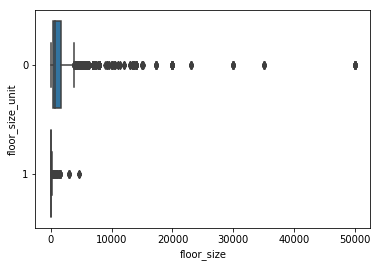

In [20]:
# Let's check the difference between floor size unit 0 and 1 
print('Floor size unit : 0')
print(transitions.loc[transitions['floor_size_unit']==0,'floor_size'].describe())
print('Floor size unit : 1\n')
print(transitions.loc[transitions['floor_size_unit']==1,'floor_size'].describe())

print('\nBoxplot depending floor size unit')
sns.boxplot(x=transitions.floor_size, y=transitions.floor_size_unit,orient="h")
print('\nIt seems to be 0 for sq feets and 1 for sq meters as  : 1 feet^2 = 0.09 m^2')

In [21]:
#verification ok 
transitions.groupby(['country','floor_size_unit']).agg('size')

country  floor_size_unit
FR       1                   5787
GB       0                  11664
         1                      6
US       0                   3605
dtype: int64

In [22]:
# put all in sq meters 
transitions.loc[:,'floor_size_m']=transitions.loc[:,'floor_size']
print(transitions.loc[:,'floor_size_m'].describe())
transitions.loc[transitions['floor_size_unit']==0,'floor_size_m']=round(transitions.loc[:,'floor_size_m']*0.09)
print(transitions.loc[:,'floor_size_m'].describe())
#anomaly sq meters below 1 
transitions = transitions.loc[transitions['floor_size_m']>1]

count    21062.000000
mean      1100.891321
std       2592.375283
min          1.000000
25%         65.000000
50%        400.000000
75%       1175.000000
max      50000.000000
Name: floor_size_m, dtype: float64
count    21062.000000
mean       126.362928
std        254.152606
min          0.000000
25%         29.000000
50%         63.000000
75%        140.000000
max       4700.000000
Name: floor_size_m, dtype: float64


## prices

different prices for each space which means : each price depends also from other parameters such as       the time booked and floor size


/anaconda/envs/ah_test_env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


There is not linear regression : price must depend from multilinear combination and from other parameters


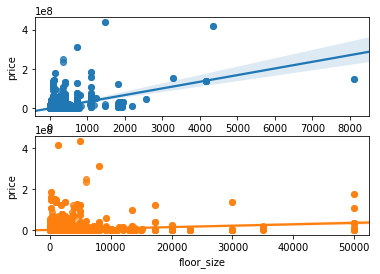

In [23]:
transitions.groupby(['space_id','price']).agg('size').to_frame().reset_index()
print('different prices for each space which means : each price depends also from other parameters such as \
      the time booked and floor size')
fig, (ax1, ax2) = plt.subplots(2, 1)
sns.regplot(x='time_booked', y="price", data=transitions,ax=ax1)
sns.regplot(x='floor_size', y="price", data=transitions,ax=ax2)
print('There is not linear regression : price must depend from multilinear combination and from other parameters')

count    2.049200e+04
mean     1.858296e+06
std      1.058641e+07
min      0.000000e+00
25%      9.000000e+04
50%      2.800000e+05
75%      9.121248e+05
max      4.386000e+08
Name: price, dtype: float64
There is a lot of outliers, even showing percentiles instead of quartiles


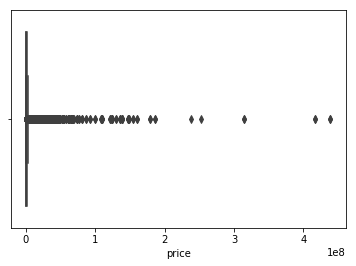

In [24]:
# price distribution
print(transitions.price.describe())
sns.boxplot(x=transitions.price,whis=[10,90])
print('There is a lot of outliers, even showing percentiles instead of quartiles')
#anomaly price equals 0
transitions = transitions[transitions['price']!=0]

## city

### supress punctuation

In [25]:
import re
transitions.loc[:,'city_ok'] = transitions.loc[:,'city']\
.apply(lambda x : re.sub("\W", " ",x))

### gather capital names

In [26]:
transitions.loc[:,'city_ok'] = transitions.loc[:,'city_ok'].str.lower().str.strip()

transitions.loc[transitions['city_ok']\
               .isin(['new york','nyc','new york city']),'city_ok']\
                     = 'new york'
transitions.loc[transitions['city_ok']\
               .str.startswith('paris'),'city_ok']\
                     = 'paris'

### add a boolean feature : capital

In [27]:
top_champ(transitions,['country'],5)

3 distinct values for the feature ['country']


,country,nb_records,percentage
0,GB,11085,54.14
1,FR,5787,28.26
2,US,3603,17.60


In [28]:
top_champ(transitions,['city_ok'],10)

84 distinct values for the feature ['city_ok']


,city_ok,nb_records,percentage
0,london,9896,48.33
1,paris,5577,27.24
2,new york,3251,15.88
3,manchester,314,1.53
4,brooklyn,284,1.39
5,brighton,184,0.90
6,birmingham,114,0.56
7,liverpool,73,0.36
8,lyon,65,0.32
9,bordeaux,53,0.26


In [29]:
transitions.loc[:,'capital']= 0
transitions.loc[transitions['city_ok']\
               .isin(['paris','new york','london']),'capital']\
                     = 1

## some booking examples

In [30]:
#transitions[transitions['space_id']==6735]
#transitions[transitions['idea_id']==105]

# total exploration

## merge ideas and transitions

In [31]:
total = pd.merge(ideas, transitions, how='left', left_on='idea_id',right_on='idea_id')

## add features

In [33]:
# time between idea creation and booking transition time
total.loc[:,'time_create_booking'] = total.loc[:,'transition_ts']- total.loc[:,'created_at']
total.loc[:,'time_create_booking'] = total.loc[:,'time_create_booking']/ np.timedelta64(1, 'D')
# time between idea creation and check-in : planification time
total.loc[:,'time_create_check_in'] = total.loc[:,'start_on']- total.loc[:,'created_at']
total.loc[:,'time_create_check_in'] = total.loc[:,'time_create_check_in']/ np.timedelta64(1, 'D')


## explore to_state

In [34]:
# first state 
total_first = total.drop_duplicates('idea_id')
top_champ(total_first,['to_state'],10)

4 distinct values for the feature ['to_state']


,to_state,nb_records,percentage
0,submitted,2324,58.10
1,unknown,1379,34.48
2,declined,296,7.40
3,booked,1,0.02


## explore time_to_request, time_to_check_in

In [35]:
print(total_first.loc[:,'time_create_booking'].describe())

count    2.621000e+03
mean     8.166390e+00
std      2.840558e+01
min      6.250000e-07
25%      1.099537e-06
50%      2.129630e-06
75%      1.106576e+00
max      3.370219e+02
Name: time_create_booking, dtype: float64


In [36]:
print(total.loc[:,'time_create_check_in'].describe())
print("There is some negative value, let's check where does it comes from")

count    20475.000000
mean        78.543068
std         69.617816
min       -100.477480
25%         31.251458
50%         56.556995
75%        106.547399
max        671.170989
Name: time_create_check_in, dtype: float64
There is some negative value, let's check where does it comes from


In [37]:
#correct errors
# total[total['time_create_check_in']<0 : same day
total.loc[total['time_create_check_in']<0,'time_create_check_in']=0
print(total.loc[:,'time_create_check_in'].describe())

count    20475.000000
mean        78.551081
std         69.605163
min          0.000000
25%         31.251458
50%         56.556995
75%        106.547399
max        671.170989
Name: time_create_check_in, dtype: float64


## explore category evolution

In [38]:
# booking lines with evolution of category feature (between idea and booking requests)
print('nb of records with evolution of category feature : %0.0f' %(total[total['category_x']!=total['category_y']].shape[0]))
# booking lines with no booking requests
print('nb of records with no booking request : %0.0f' %(total[total['category_y'].isnull()].shape[0]))
# nb of ideas without bookings requests
idea_id_unknown = total.loc[total['category_y'].isnull(),'idea_id'].unique()
print('nb of ideas without bookings requests %0.0f' %len(idea_id_unknown))

nb of records with evolution of category feature : 1379
nb of records with no booking request : 1379
nb of ideas without bookings requests 1379


### ideas without booking requests

In [39]:
min_created_ukn = min(ideas.loc[ideas['idea_id'].isin(idea_id_unknown),'created_at'])
max_created_ukn = max(ideas.loc[ideas['idea_id'].isin(idea_id_unknown),'created_at'])
print('There are %0.0f ideas unknown' %len(idea_id_unknown))
print('Ideas unknown have been created from %s to %s' %(min_created_ukn, max_created_ukn))

There are 1379 ideas unknown
Ideas unknown have been created from 2018-01-01 17:01:01.489000 to 2019-01-21 10:19:35.205000


In [40]:
top_champ(ideas[ideas['idea_id'].isin(idea_id_unknown)],['category'],10)

6 distinct values for the feature ['category']


,category,nb_records,percentage
0,popup_shop,760,55.11
1,popup_bar,240,17.40
2,unique,145,10.51
3,private_event,134,9.72
4,gallery,78,5.66
5,sample_sale,22,1.60


### ideas with booking requests

In [41]:
idea_id_known = total.loc[total['category_y'].notnull(),'idea_id'].unique()
min_created_ukn = min(ideas.loc[ideas['idea_id'].isin(idea_id_known),'created_at'])
max_created_ukn = max(ideas.loc[ideas['idea_id'].isin(idea_id_known),'created_at'])
print('There are %0.0f ideas with at least one request submitted' %(len(idea_id_known)))
print('Ideas with requests have been created from %s to %s' %(min_created_ukn, max_created_ukn))

There are 2621 ideas with at least one request submitted
Ideas with requests have been created from 2018-01-02 15:21:32.044000 to 2019-01-15 14:54:49.719000


In [42]:
top_champ(ideas[ideas['idea_id'].isin(idea_id_known)],['category'],10)

6 distinct values for the feature ['category']


,category,nb_records,percentage
0,popup_shop,1414,53.95
1,private_event,412,15.72
2,popup_bar,293,11.18
3,unique,253,9.65
4,gallery,204,7.78
5,sample_sale,45,1.72


## supress idea without booking requests

We don't have enough informations about ideas without booking requests to make interpretation about it
It could also be because : booking requests for those ideas are not in this transition dataset but in the real database

In [43]:
total_ok = total.loc[total['idea_id'].isin(idea_id_known)]

# conversion table

Creation of tables showing the different patterns between the first request and the booking or declination of a request

In [44]:
print(transitions.drop_duplicates(['booking_request_id','city','space_id']).shape)
transitions.drop_duplicates(['booking_request_id']).shape

(9676, 26)


(9676, 26)

## pattern for each booking_id (1space for 1 particular idea)

In [45]:
conversion = total_ok.groupby(['idea_id','space_id','booking_request_id'])['to_state'].\
apply(lambda x: "%s" % ' / '.join(x)).to_frame().reset_index()
#conversion
#top_champ(conversion,['to_state'],10)
conversion.loc[:,'ending_stage'] = conversion.loc[:,'to_state'].apply(lambda x : x.split(' ')[-1])

In [46]:
top_champ(conversion,['idea_id','ending_stage'],5)\
.sort_values(['ending_stage','nb_records'],ascending=True)
#conversion

2998 distinct values for the feature ['idea_id', 'ending_stage']


,idea_id,ending_stage,nb_records,percentage
3,2988,declined,38,0.39
4,1229,declined,38,0.39
2,2364,declined,45,0.47
1,1255,declined,48,0.50
0,3650,declined,156,1.61


In [47]:
top_champ(conversion[conversion.ending_stage=='submitted'],['to_state'],100)

4 distinct values for the feature ['to_state']


,to_state,nb_records,percentage
0,submitted,303,95.58
1,submitted / submitted,8,2.52
2,submitted / declined / submitted,5,1.58
3,submitted / submitted / submitted,1,0.32


## new pattern each time there is a submission

In [48]:
conversion_2 = conversion\
.join(conversion['to_state'].str.split(' / s', expand=True)\
      .stack().reset_index(level=1, drop=True).rename('to_state_2'))
conversion_2.loc[:,'to_state_2'] = conversion_2['to_state_2'].str.replace('ubmitted','submitted')
conversion_2.loc[:,'to_state_2'] = conversion_2['to_state_2'].str.replace('ssubmitted','submitted')
conversion_2.loc[:,'ending_stage_2'] = conversion_2.loc[:,'to_state_2'].apply(lambda x : x.split(' ')[-1])



In [49]:
top_champ(conversion_2,['to_state'],5)

59 distinct values for the feature ['to_state']


,to_state,nb_records,percentage
0,submitted / declined,4780,47.07
1,declined,1827,17.99
2,submitted / matched / declined,1753,17.26
3,submitted,303,2.98
4,submitted / matched / booked,297,2.92


# MCA on R bookings ok

To make an MCA we need "factor" features which means categories.        
Hence, we only keep features with categories     
**Goal** : explore the relations between features and once the new reduced axis are created, projection of the feature to predict "ending_stage"

In [50]:
total_ok.loc[total_ok['floor_size_m']>   200,'floor_size_cat'] = 'sup_200'
total_ok.loc[total_ok['floor_size_m']<=  200,'floor_size_cat'] = '100_200'
total_ok.loc[total_ok['floor_size_m']<   100,'floor_size_cat'] = '80_100'
total_ok.loc[total_ok['floor_size_m']<    80,'floor_size_cat'] = '60_80'
total_ok.loc[total_ok['floor_size_m']<    60,'floor_size_cat'] = '40_60'
total_ok.loc[total_ok['floor_size_m']<    40,'floor_size_cat'] = '20_40'
total_ok.loc[total_ok['floor_size_m']<    20,'floor_size_cat'] = 'inf_20'
top_champ(total_ok,['floor_size_cat'],10)

/anaconda/envs/ah_test_env/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/anaconda/envs/ah_test_env/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


7 distinct values for the feature ['floor_size_cat']


,floor_size_cat,nb_records,percentage
0,100_200,3694,18.04
1,20_40,3659,17.87
2,sup_200,3256,15.90
3,40_60,3049,14.89
4,inf_20,2814,13.74
5,60_80,2156,10.53
6,80_100,1847,9.02


In [51]:
#price categories
total_ok.loc[total_ok['price']>   5000000,'price_category'] = 'sup_5millions'
total_ok.loc[total_ok['price']<=  5000000,'price_category'] = '1_5millions'
total_ok.loc[total_ok['price']<   1000000,'price_category'] = '500k_1millions'
total_ok.loc[total_ok['price']<    500000,'price_category'] = '200k_500k'
total_ok.loc[total_ok['price']<    300000,'price_category'] = '100k_200k'
total_ok.loc[total_ok['price']<    100000,'price_category'] = '50k_100k'
total_ok.loc[total_ok['price']<     50000,'price_category'] = '10k_50k'
total_ok.loc[total_ok['price']<     10000,'price_category'] = 'inf_10k'

top_champ(total_ok,['price_category'],10)

8 distinct values for the feature ['price_category']


,price_category,nb_records,percentage
0,100k_200k,5085,24.84
1,1_5millions,3685,18.00
2,500k_1millions,2674,13.06
3,10k_50k,2651,12.95
4,200k_500k,2365,11.55
5,50k_100k,2253,11.00
6,sup_5millions,1230,6.01
7,inf_10k,532,2.60


In [52]:
total_ok.loc[total_ok['time_create_booking']>15,'after_creation'] = 'sup_15j'
total_ok.loc[total_ok['time_create_booking']<=15,'after_creation'] = '3j_15j'
total_ok.loc[total_ok['time_create_booking']<3,'after_creation'] = '1j_3j'
total_ok.loc[total_ok['time_create_booking']<1,'after_creation'] = '1h_1j'
total_ok.loc[total_ok['time_create_booking']<0.04,'after_creation'] = '10s_1h'
total_ok.loc[total_ok['time_create_booking']<0.0001,'after_creation'] = 'less_10s'
top_champ(total_ok.drop_duplicates('idea_id'),['after_creation'],10)
# More than an half of the ideas transforms in a request in less than 10 seconds

6 distinct values for the feature ['after_creation']


,after_creation,nb_records,percentage
0,less_10s,1521,58.03
1,sup_15j,282,10.76
2,3j_15j,274,10.45
3,10s_1h,231,8.81
4,1h_1j,200,7.63
5,1j_3j,113,4.31


In [53]:
bookings_mca = pd.merge(conversion[['booking_request_id','to_state','ending_stage']],
                      total_ok.drop_duplicates('booking_request_id')\
                       [['booking_request_id',
                         'country', 'city','city_ok','capital',
                         'portfolio_type', 'floor_size_cat','price_category',
                         'time_booked', 'time_create_booking', 'after_creation']],\
                       how='inner', on = 'booking_request_id')

In [54]:
# reservation more than 1 day (without bug)
bookings_mca =bookings_mca[bookings_mca['time_booked']>0]

In [55]:
bookings_mca['time_booked'].describe()

count    7841.000000
mean       54.971815
std       192.477730
min         1.000000
25%         4.000000
50%         8.000000
75%        30.000000
max      8115.000000
Name: time_booked, dtype: float64

In [56]:
bookings_mca.loc[bookings_mca['time_booked']> 30,'times_booked_cat'] = 'sup_30'
bookings_mca.loc[bookings_mca['time_booked']<=30,'times_booked_cat'] = '15_30'
bookings_mca.loc[bookings_mca['time_booked']< 15,'times_booked_cat'] = '10_15'
bookings_mca.loc[bookings_mca['time_booked']< 10,'times_booked_cat'] = '7_10'
bookings_mca.loc[bookings_mca['time_booked']< 7,'times_booked_cat'] = '5_7'
bookings_mca.loc[bookings_mca['time_booked']< 5,'times_booked_cat'] = '3_5'
bookings_mca.loc[bookings_mca['time_booked']< 3,'times_booked_cat'] = 'inf_3'

In [57]:
top_champ(bookings_mca,['times_booked_cat'],100)

7 distinct values for the feature ['times_booked_cat']


,times_booked_cat,nb_records,percentage
0,sup_30,1699,21.67
1,inf_3,1548,19.74
2,5_7,1269,16.18
3,15_30,1139,14.53
4,10_15,867,11.06
5,3_5,671,8.56
6,7_10,648,8.26


In [58]:
bookings_mca.to_csv('bookings_mca.csv') 

In [59]:
# finished bookings : either declined or booking
bookings_mca = bookings_mca[bookings_mca['ending_stage'].isin(['declined','booked'])]

In [60]:
top_champ(bookings_mca,['ending_stage'],100)

2 distinct values for the feature ['ending_stage']


,ending_stage,nb_records,percentage
0,declined,7254,96.31
1,booked,278,3.69


In [61]:
bookings_mca.columns

Index(['booking_request_id', 'to_state', 'ending_stage', 'country', 'city',
       'city_ok', 'capital', 'portfolio_type', 'floor_size_cat',
       'price_category', 'time_booked', 'time_create_booking',
       'after_creation', 'times_booked_cat'],
      dtype='object')

# ML 

In [62]:
#from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score

## Create bookings_ml

### Select the feature to predict

In [63]:
top_champ(conversion,['ending_stage'],5)

4 distinct values for the feature ['ending_stage']


,ending_stage,nb_records,percentage
0,declined,8905,92.03
1,booked,375,3.88
2,submitted,317,3.28
3,matched,79,0.82


Hence we have four types of ending stage for a booking :
- declined : which means the client refused the idea or they weren't any available spaces
- booked : which means the client successfully booked a space
- matched : which means the space is avalaible and fits the booking request
- submitted : which means the client or appear here teams have made a booking request for one space

In the case of the ending-stage equals to submitted it means the booking request have just been made and so it is impossible to know wwhether the space fits the request (availability and client ideas) so we cannot make any training prediction or testing prediction on this 3% of the dataset.   
regarding the matched ending-stage, it is means that the space is available but does not mean that the client accept it.
I could gather this ending_stage with the booked one but I also want to predict whether the client will or won't reserve the space so I prefered to keep only booked ending-stage. Besides, one client idea can have several bookings matching availaibility and still he will select only one among others. It seems interesting to also predict why this space availaible among other spaces available.

#### select ending_stage declined or booked

In [69]:
bookings_ml = total_ok.drop_duplicates('booking_request_id',keep='last')
bookings_ml = bookings_ml.loc[bookings_ml['to_state'].isin(['booked','declined'])]

#### transform ending_stage in boolean features

In [75]:
bookings_ml.loc[bookings_ml['to_state']=='booked','ending_stage'] = 1
bookings_ml.loc[bookings_ml['to_state']=='declined','ending_stage'] = 0
bookings_ml = bookings_ml.drop(['to_state'],axis=1)

In [76]:
top_champ(bookings_ml,['ending_stage'],2)

2 distinct values for the feature ['ending_stage']


,ending_stage,nb_records,percentage
0,0.0,8905,95.96
1,1.0,375,4.04


### Calculate some other features 

#### number of booking booked per space

In [78]:
space_info = bookings_ml.loc[bookings_ml['ending_stage']==1].groupby('space_id').agg('size').to_frame().reset_index()
space_info.columns = ['space_id','nb_space_booked']

#### number of bookings booked per idea

In [80]:
idea_info = bookings_ml.loc[bookings_ml['ending_stage']==1].groupby('idea_id').agg('size').to_frame().reset_index()
idea_info.columns = ['idea_id','nb_booked']

#### fidelity of the idea 

Time between last booking state (= last activity) and the creation of the idea 

In [81]:
bookings_ml.loc[:,'idea_age'] = bookings_ml.loc[:,'time_create_booking'] 
#print(idea_old.loc[:,'idea_age'].describe())
bookings_ml = bookings_ml.drop(['time_create_booking'],axis=1)
#idea_old = idea_old[['idea_id','idea_age']]

#### time between idea creation and first booking request

In [83]:
time_fst_booking = total_ok.drop_duplicates('booking_request_id',keep='first').copy()
time_fst_booking = time_fst_booking[['booking_request_id','time_create_booking']]
time_fst_booking.columns = ['booking_request_id','time_fst_booking']
#time_fst_booking = time_fst_booking.drop_duplicates('idea_id',keep='first')

### merge all and keep useful features

In [85]:
bookings_ml = bookings_ml[['booking_request_id', 'ending_stage','time_create_check_in','idea_age',
            'idea_id', 'category_x', 'created_at_year','created_at_mth',  
            'to_state_bf','transition_ts_year', 'transition_ts_mth',
            'space_id', 'country',  'capital', 'portfolio_type','price' , 'floor_size_m', 
            'start_on_year', 'start_on_mth', 'end_on_year', 'end_on_month', 'time_booked']]          

In [86]:
print(bookings_ml.shape)
bookings_ml = pd.merge(bookings_ml, idea_info, how='left', left_on='idea_id', right_on='idea_id')
print(bookings_ml.shape)
bookings_ml = pd.merge(bookings_ml, time_fst_booking, how='left', left_on='booking_request_id', right_on='booking_request_id')
print(bookings_ml.shape)
bookings_ml = pd.merge(bookings_ml, space_info, how='left', left_on='space_id', right_on='space_id')
print(bookings_ml.shape)

(9280, 22)
(9280, 23)
(9280, 24)
(9280, 25)


In [87]:
top_champ(bookings_ml,['capital'],2)

2 distinct values for the feature ['capital']


,capital,nb_records,percentage
0,1.0,8552,92.16
1,0.0,728,7.84


#### change string and nan by integer

In [101]:
#check nan
for i in range(24) : 
    sum_na = bookings_ml.iloc[:,i].isnull().sum()#.sum()
    if sum_na !=0 : print(i)

21


In [105]:
bookings_ml.loc[bookings_ml['nb_booked'].isnull(),'nb_booked']= 0

In [106]:
bookings_ml.loc[bookings_ml['nb_space_booked'].isnull(),'nb_space_booked']= 0

#### replace category feature by one hot encoding feature for each category

In [107]:
bookings_ml.loc[:,'popupshop']= 0
bookings_ml.loc[bookings_ml['category_x']=='popup_shop','popupshop']= 1

bookings_ml.loc[:,'private_event']= 0
bookings_ml.loc[bookings_ml['category_x']=='private_event','private_event']= 1

bookings_ml.loc[:,'unique']= 0
bookings_ml.loc[bookings_ml['category_x']=='unique','unique']= 1

bookings_ml.loc[:,'popup_bar']= 0
bookings_ml.loc[bookings_ml['category_x']=='popup_bar','popup_bar']= 1

bookings_ml.loc[:,'gallery']= 0
bookings_ml.loc[bookings_ml['category_x']=='gallery','gallery']= 1

bookings_ml.loc[:,'sample_sale']= 0
bookings_ml.loc[bookings_ml['category_x']=='sample_sale','sample_sale']= 1

bookings_ml = bookings_ml.drop(['category_x'],axis=1)

KeyError: 'category_x'

In [108]:
bookings_ml.loc[:,'bf_matched']= 0
bookings_ml.loc[bookings_ml['to_state_bf']=='matched','bf_matched']= 1

bookings_ml.loc[:,'bf_submitted']= 0
bookings_ml.loc[bookings_ml['to_state_bf']=='submitted','bf_submitted']= 1

bookings_ml.loc[:,'bf_declined']= 0
bookings_ml.loc[bookings_ml['to_state_bf']=='declined','bf_declined']= 1

bookings_ml.loc[:,'bf_booked']= 0
bookings_ml.loc[bookings_ml['to_state_bf']=='booked','bf_booked']= 1

bookings_ml = bookings_ml.drop(['to_state_bf'],axis=1)

KeyError: 'to_state_bf'

In [109]:
bookings_ml.loc[:,'country_GB'] = 0
bookings_ml.loc[bookings_ml['country']=='GB','country_GB']= 1

bookings_ml.loc[:,'country_FR']= 0
bookings_ml.loc[bookings_ml['country']=='FR','country_FR']= 1

bookings_ml.loc[:,'country_US']= 0
bookings_ml.loc[bookings_ml['country']=='US','country_US']= 1

bookings_ml = bookings_ml.drop(['country'],axis=1)

KeyError: 'country'

## correlations

Text(0.5, 1.0, 'Represents the correlations betweeen features')

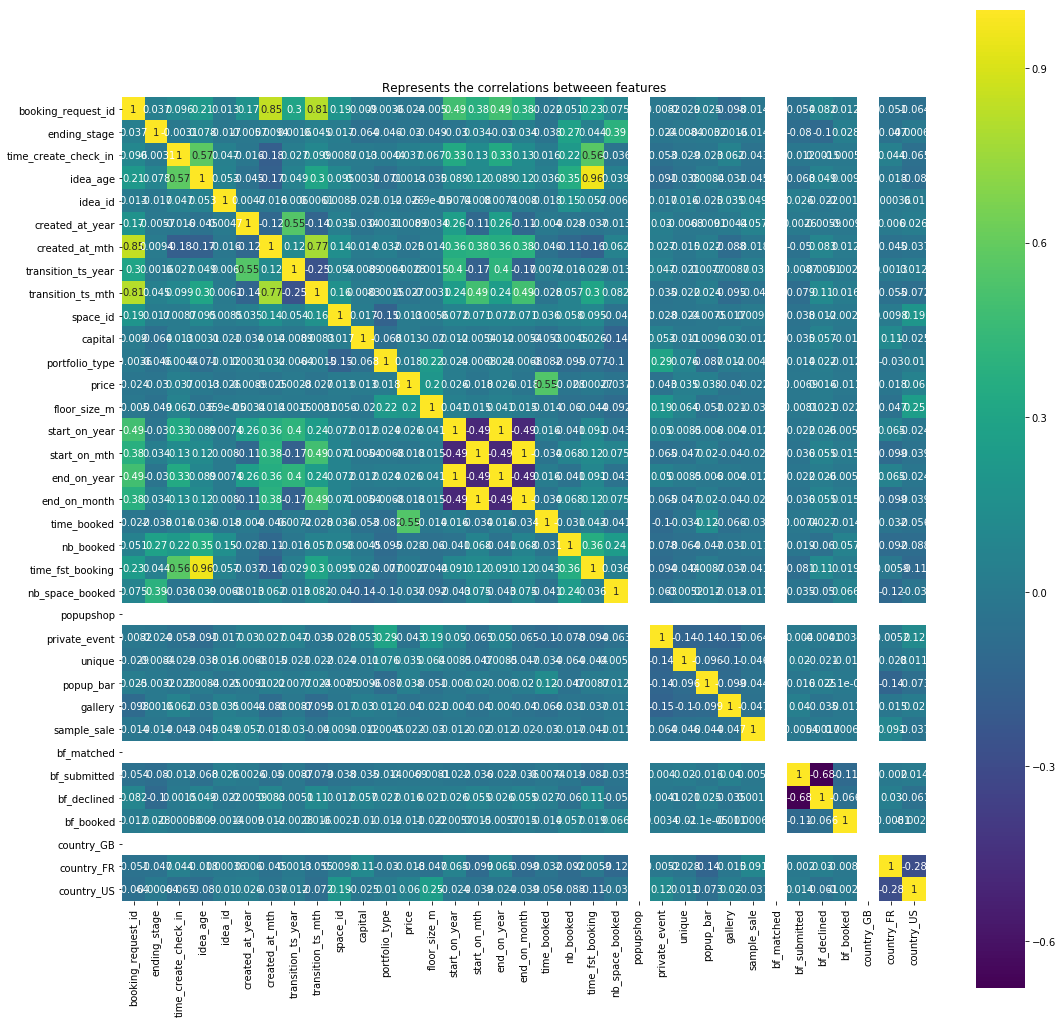

In [110]:
tab_corr = bookings_ml.corr()
plt.figure(figsize=(18, 18))
sns.heatmap(tab_corr, vmax=1, square=True,annot=True,cmap='viridis')
plt.title('Represents the correlations betweeen features')

There are a few highly correlated variable.
- idea_age and time_to_request
- transition_mth and booking_request_id 
- created_at_mth and booking_request_id 
- transition_mth and created_at_month 
We keep them as we are going to use the PCA for randomforest and logistic regression which are algorithms robust to correlations

## imbalanced data

In [111]:
#top_champ(booking_ml,['ending_stage','to_state'],100)
#booking_ml = booking_ml.drop(['to_state'],axis=1)
top_champ(bookings_ml,['ending_stage'],100)

2 distinct values for the feature ['ending_stage']


,ending_stage,nb_records,percentage
0,0.0,8905,95.96
1,1.0,375,4.04


It is impossible to make a good prediction with such imbalanced data : 95% compare to 4%.   
Hence, we need an equal chance to predict the booking booked and the booking declined. 
So we randomly choose 375 recors among the 8905 declined examples.

In [112]:
bookings_ml = bookings_ml.reset_index(drop=True)
bk_ml_sample = bookings_ml[bookings_ml['ending_stage']==1]

declined_index = bookings_ml[bookings_ml['ending_stage']==0].index
random_dc_index = np.random.choice(declined_index,int(sum(bookings_ml['ending_stage'])),replace=False)
dc_ml_sample = bookings_ml.loc[random_dc_index]

bookings_ml_ok = pd.concat([bk_ml_sample,dc_ml_sample],axis=0)
print('Percentage of bookings booked %0.1f' %(len(bookings_ml_ok[bookings_ml_ok['ending_stage']==1])/len(bookings_ml_ok)))
print('Percentage of bookings declined %0.1f' %(len(bookings_ml_ok[bookings_ml_ok['ending_stage']==0])/len(bookings_ml_ok)))
print('Number of records for bookings_ml_ok %0.0f' %(len(bookings_ml_ok)))

Percentage of bookings booked 0.5
Percentage of bookings declined 0.5
Number of records for bookings_ml_ok 750


Now, the data are well balanced and the prediction won't be biased 

In [113]:
top_champ(bookings_ml_ok,['ending_stage'],100)

2 distinct values for the feature ['ending_stage']


,ending_stage,nb_records,percentage
0,1.0,375,50.0
1,0.0,375,50.0


#### shuffle

In [114]:
bookings_ml_ok
bookings_ml_ok = bookings_ml_ok.loc[np.random.permutation(bookings_ml_ok.index)]

Now the data is well shuflled and booked and declined are permuted randomly in the dataset

#### X, y

In [115]:
# features parameters
X = bookings_ml_ok.loc[:, bookings_ml_ok.columns != 'ending_stage']
# feature to predict
y = bookings_ml_ok.loc[:, bookings_ml_ok.columns == 'ending_stage']

## Random forest

### split train, test

In [116]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

/anaconda/envs/ah_test_env/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/ah_test_env/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [117]:
pca = PCA(n_components=23)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=23, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [118]:
var = np.cumsum(np.round(pca.explained_variance_ratio_,decimals=3)*100)
var

array([13.8, 24.5, 33.2, 40.2, 46. , 51.2, 55.8, 60. , 64. , 67.7, 71.3,
       74.7, 77.9, 81. , 84. , 86.3, 88.6, 90.7, 92.4, 94. , 95.6, 97. ,
       98.3])

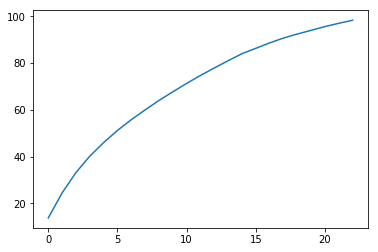

In [119]:
plt.plot(var)

## random forest

In [120]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)  

In [121]:
classifier = RandomForestClassifier(max_depth=2,random_state=0)
classifier.fit(X_train, y_train)

/anaconda/envs/ah_test_env/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda/envs/ah_test_env/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [122]:
y_pred = classifier.predict(X_test)

cm = confusion_matrix(y_test,y_pred)
print(cm)
print(accuracy_score(y_test,y_pred))


[[106  13]
 [  5 101]]
0.92


In [123]:
print(precision_score(y_test,y_pred))
print(recall_score(y_test,y_pred))

0.8859649122807017
0.9528301886792453


## Logistic regression

In [125]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

logReg=LogisticRegression()

logReg.fit(X_train,y_train)
y_pred_2 = logReg.predict(X_test)

cm_2 = confusion_matrix(y_test,y_pred_2)
print(cm_2)
print(accuracy_score(y_test,y_pred_2))


[[110   9]
 [ 11  95]]
0.9111111111111111


/anaconda/envs/ah_test_env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda/envs/ah_test_env/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### improve hyper parameters

In [348]:
np.mean(y_train)[0]

0.49142857142857144